## Loading and plotting the data

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("Tweets.csv", header=0, delimiter=",", quoting=0)

In [2]:
df.head(4)
#Converting the sentiment to numerical data to plot the histogram
for i in range(len(df)):
    if df.airline_sentiment[i]=='positive':
        df.loc[i,'sentiment'] = int(1)
    elif df.airline_sentiment[i]=='negative':
        df.loc[i,'sentiment'] = int(-1)
    elif df.airline_sentiment[i]=='neutral':
        df.loc[i,'sentiment'] = int(0)

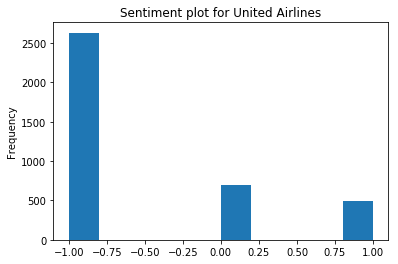

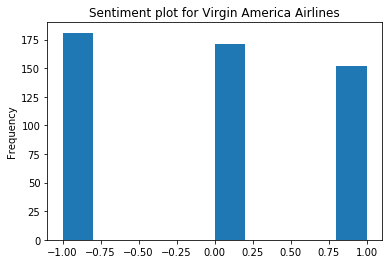

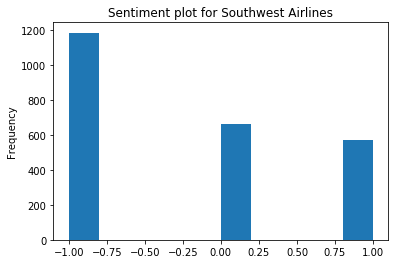

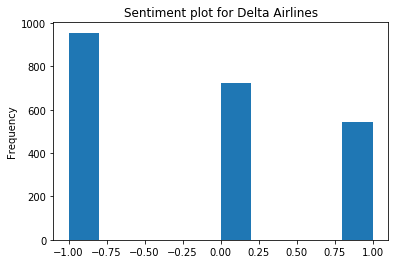

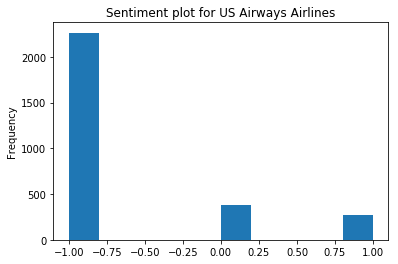

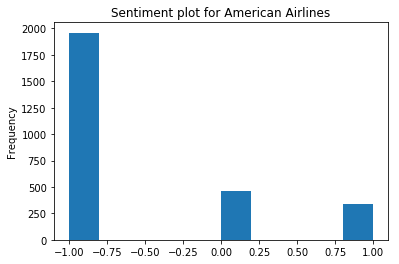

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(111)
df[df['airline']=='United']['sentiment'].plot.hist()
plt.title("Sentiment plot for United Airlines")
plt.show() 

plt.subplot(111)
df[df['airline']=='Virgin America']['sentiment'].plot.hist()
plt.title("Sentiment plot for Virgin America Airlines")
plt.show()

plt.subplot(111)
df[df['airline']=='Southwest']['sentiment'].plot.hist()
plt.title("Sentiment plot for Southwest Airlines")
plt.show()

plt.subplot(111)
df[df['airline']=='Delta']['sentiment'].plot.hist()
plt.title("Sentiment plot for Delta Airlines")
plt.show()

plt.subplot(111)
df[df['airline']=='US Airways']['sentiment'].plot.hist()
plt.title("Sentiment plot for US Airways Airlines")
plt.show()

plt.subplot(111)
df[df['airline']=='American']['sentiment'].plot.hist()
plt.title("Sentiment plot for American Airlines")
plt.show()


## Removing mentons and URLs and converting # to _hashtag

In [3]:
import re
regexp_mention = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'
pattern_mention = re.compile(regexp_mention, re.UNICODE | re.IGNORECASE)

for i in range(len(df)):
    df.loc[i,'text']  = pattern_mention.sub("", df.text[i])
#print(df.TextnoMen)

In [4]:
regexp_url = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
pattern_url = re.compile(regexp_url, re.UNICODE | re.IGNORECASE)

for i in range(len(df)):
    df.loc[i,'text']  = pattern_url.sub("", df.text[i])

In [5]:
regexp_hashtag = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)'
pattern_hashtag = re.compile(regexp_hashtag, re.UNICODE | re.IGNORECASE)

for i in range(len(df)):
    df.loc[i,'text'] = pattern_hashtag.sub(r'hashtag_\1', df.text[i])

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics  import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

#Creating different datasets based on Airline
df = df.sample(frac=1, random_state= 100)

print(df.airline.unique())
dfUnited = df[df.airline=='United']
dfAmerican = df[df.airline=='American']
dfSouthwest = df[df.airline=='Southwest']
dfDelta = df[df.airline=='Delta']
dfUSAir = df[df.airline=='US Airways']
dfVirgin = df[df.airline=='Virgin America']


['American' 'United' 'Southwest' 'US Airways' 'Virgin America' 'Delta']


## Function for Logistic Regression model with 10-fold cross validation

In [25]:
from sklearn.model_selection import KFold
def CreateModelLR(df):
    
    df_text = df['text']
    df_sentiment = df['sentiment']
    
    Accuracylist = []
    f1scorelist = []
    CVaccuracy = []
    CVf1Score = []
    
    kf = KFold(n_splits=10, shuffle = True, random_state = 2)
    
    
    for i in range(1,10) : 
        for train, valid in kf.split(df_sentiment):

            X_train_text = df_text.iloc[train]
            yTrain = df_sentiment.iloc[train]

            X_valid_text = df_text.iloc[valid]
            yValid = df_sentiment.iloc[valid]

            #print("Total number of records = %d" %len(df))
            #print("Train and Test : %s and %s" %(yTrain.shape, yValid.shape))

            vect = CountVectorizer(binary = False, min_df = 5, stop_words = 'english')

            XTrain = vect.fit_transform(X_train_text)
            #print(XTrain.shape)

            XValid = vect.transform(X_valid_text)
            #print(XValid.shape)

            LogR = LogisticRegression(C = 5)
            LogR.fit(XTrain, yTrain)

            Predited = LogR.predict(XValid)

            Accuracylist.append(accuracy_score(yValid, Predited))
            f1scorelist.append(f1_score(yValid, Predited, average = "weighted"))

            performance=[]
            f1Score = np.array(f1scorelist).mean(0)
            Accuracy = np.array(Accuracylist).mean(0)
        
        CVaccuracy.append(Accuracy)
        CVf1Score.append(f1Score)
    #performace = [Acuracy,f1Score]
    #print(CVaccuracy)
    #print(CVf1Score)
    minAccidx = np.array(CVaccuracy).argmax()
   
    airline = set(df.airline)
    print("LOGISTIC REGRESSION")
    print("Airlines = %s ; Best Cross validation Accuracy of the model is %f ; F1-Score is %f" % (airline,CVaccuracy[minAccidx],CVf1Score[minAccidx]))
    print("----------------------------------------------------------------------------------------------")
    print("")

## Function for Naive Bayes model with 10-fold cross validation

In [24]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
def CreateModelNB(df):
    
    df_text = df['text']
    df_sentiment = df['sentiment']
    
    Accuracylist = []
    f1scorelist = []
    CVaccuracy = []
    CVf1Score = []
    
    kf = KFold(n_splits=10, shuffle = True, random_state = 2)
    alpha = [1e-8, 5e-8,1e-7, 5e-7,1e-6, 5e-6,1e-5, 5e-5,1e-4, 5e-4,1e-3, 5e-3,1e-2, 5e-2,1e-1, 5e-1 ]
    
    for i in alpha : 
        for train, valid in kf.split(df_sentiment):

            X_train_text = df_text.iloc[train]
            yTrain = df_sentiment.iloc[train]

            X_valid_text = df_text.iloc[valid]
            yValid = df_sentiment.iloc[valid]

            #print("Total number of records = %d" %len(df))
            #print("Train and Test : %s and %s" %(yTrain.shape, yValid.shape))

            vect = CountVectorizer(binary = False, min_df = 5, stop_words = 'english')

            XTrain = vect.fit_transform(X_train_text)
            #print(XTrain.shape)

            XValid = vect.transform(X_valid_text)
            #print(XValid.shape)

            MNB = MultinomialNB(i)
            MNB.fit(XTrain, yTrain)

            Predited = MNB.predict(XValid)

            Accuracylist.append(accuracy_score(yValid, Predited))
            f1scorelist.append(f1_score(yValid, Predited, average = "weighted"))

            performance=[]
            f1Score = np.array(f1scorelist).mean(0)
            Accuracy = np.array(Accuracylist).mean(0)
        
        CVaccuracy.append(Accuracy)
        CVf1Score.append(f1Score)
    #performace = [Acuracy,f1Score]
    #print(CVaccuracy)
    #print(CVf1Score)
    minAccidx = np.array(CVaccuracy).argmax()
    
    airline = set(df.airline)
    print("NAIVE BAYES")
    print("Airlines = %s ; Best Cross validation Accuracy of the model is %f ; F1-Score is %f" % (airline,CVaccuracy[minAccidx],CVf1Score[minAccidx]))
    print("----------------------------------------------------------------------------------------------")
    print("")

## United Airlines

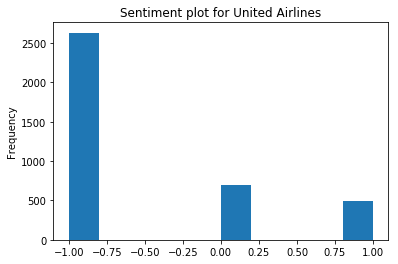

LOGISTIC REGRESSION
Airlines = {'United'} ; Best Cross validation Accuracy of the model is 0.738361 ; F1-Score is 0.730933
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'United'} ; Best Cross validation Accuracy of the model is 0.730942 ; F1-Score is 0.712509
----------------------------------------------------------------------------------------------



In [26]:
df[df['airline']=='United']['sentiment'].plot.hist()
plt.title("Sentiment plot for United Airlines")
plt.show()
CreateModelLR(dfUnited)
CreateModelNB(dfUnited)

## American Airlines
The data is quite unbalanced as the number of negative sentiments are higher than the number of positive and neutral sentiments. We see that in this case, the performance of logistic regression and naive bayes are comparable, while logistic regression performs slightly better.

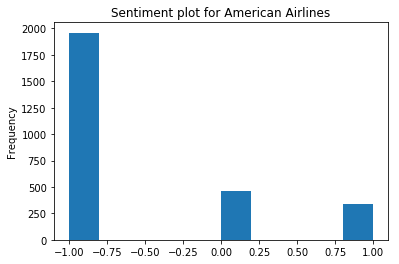

LOGISTIC REGRESSION
Airlines = {'American'} ; Best Cross validation Accuracy of the model is 0.777830 ; F1-Score is 0.769012
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'American'} ; Best Cross validation Accuracy of the model is 0.774473 ; F1-Score is 0.755963
----------------------------------------------------------------------------------------------



In [27]:
df[df['airline']=='American']['sentiment'].plot.hist()
plt.title("Sentiment plot for American Airlines")
plt.show()
CreateModelLR(dfAmerican)
CreateModelNB(dfAmerican)

## Southwest Airlines
The data is almost balanced. We see that in this case, the performance of logistic regressiona nd naive bayes are comparable, while logistic regression performs better.

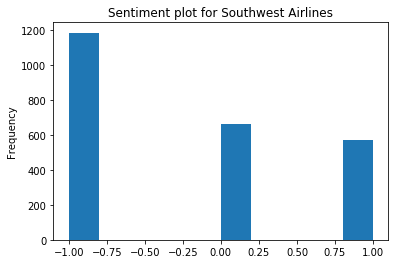

LOGISTIC REGRESSION
Airlines = {'Southwest'} ; Best Cross validation Accuracy of the model is 0.696694 ; F1-Score is 0.696873
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'Southwest'} ; Best Cross validation Accuracy of the model is 0.674225 ; F1-Score is 0.667970
----------------------------------------------------------------------------------------------



In [28]:
df[df['airline']=='Southwest']['sentiment'].plot.hist()
plt.title("Sentiment plot for Southwest Airlines")
plt.show()
CreateModelLR(dfSouthwest)
CreateModelNB(dfSouthwest)

## Delta Airlines
The data is almost balanced. We see that in this case, the performance of logistic regressiona nd naive bayes are comparable, while logistic regression performs a little better.

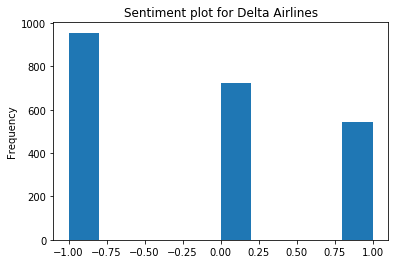

LOGISTIC REGRESSION
Airlines = {'Delta'} ; Best Cross validation Accuracy of the model is 0.659756 ; F1-Score is 0.660522
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'Delta'} ; Best Cross validation Accuracy of the model is 0.654744 ; F1-Score is 0.648567
----------------------------------------------------------------------------------------------



In [29]:
df[df['airline']=='Delta']['sentiment'].plot.hist()
plt.title("Sentiment plot for Delta Airlines")
plt.show()
CreateModelLR(dfDelta)
CreateModelNB(dfDelta)

## US Airways 
The data is quite unbalanced as the number of negative sentiments are higher than the number of positive and neutral sentiments. We see that in this case, the performance of logistic regression and naive bayes are comparable, while naive bayes performs a little better. 

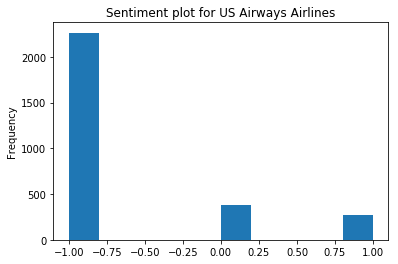

LOGISTIC REGRESSION
Airlines = {'US Airways'} ; Best Cross validation Accuracy of the model is 0.797452 ; F1-Score is 0.785558
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'US Airways'} ; Best Cross validation Accuracy of the model is 0.800280 ; F1-Score is 0.781623
----------------------------------------------------------------------------------------------



In [30]:
df[df['airline']=='US Airways']['sentiment'].plot.hist()
plt.title("Sentiment plot for US Airways Airlines")
plt.show()
CreateModelLR(dfUSAir)
CreateModelNB(dfUSAir)

## Virgin America
We see that the data is balanced as there are almost equal number of positive, negative and neutral sentiments. In this case logistic regression performes quite better than Naive Bayes. 

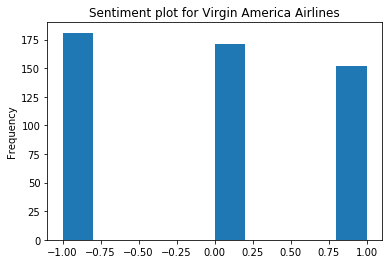

LOGISTIC REGRESSION
Airlines = {'Virgin America'} ; Best Cross validation Accuracy of the model is 0.617176 ; F1-Score is 0.616349
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'Virgin America'} ; Best Cross validation Accuracy of the model is 0.515311 ; F1-Score is 0.510615
----------------------------------------------------------------------------------------------



In [31]:
df[df['airline']=='Virgin America']['sentiment'].plot.hist()
plt.title("Sentiment plot for Virgin America Airlines")
plt.show()
CreateModelLR(dfVirgin)
CreateModelNB(dfVirgin)

## All Airlines

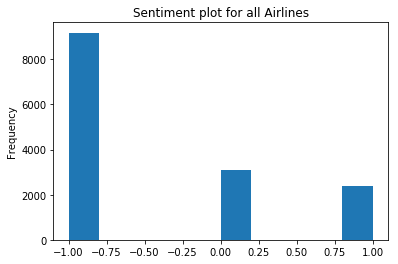

LOGISTIC REGRESSION
Airlines = {'Southwest', 'United', 'US Airways', 'Delta', 'Virgin America', 'American'} ; Best Cross validation Accuracy of the model is 0.768238 ; F1-Score is 0.765284
----------------------------------------------------------------------------------------------

NAIVE BAYES
Airlines = {'Southwest', 'United', 'US Airways', 'Delta', 'Virgin America', 'American'} ; Best Cross validation Accuracy of the model is 0.757006 ; F1-Score is 0.748709
----------------------------------------------------------------------------------------------



In [32]:
df['sentiment'].plot.hist()
plt.title("Sentiment plot for all Airlines")
plt.show()
CreateModelLR(df)
CreateModelNB(df)

## Changing the percentage of training data while reserving 20% for test
There are two stark observations that can be made from the graph above:
1. We can see that the perfomance of both the models improves with the increase in the percentage of the training data. For each of the models, 80% training and 20% test gives the best performance
2. It can be notices that overall, logistic regression performs better on this data and gives a higher accuracy at all percentages of training data. 

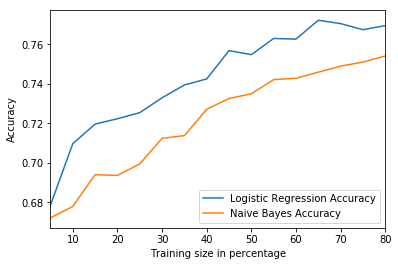

In [34]:
#Deviding into test and train - Train:test :: 80%:20%

def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

AccuracylistLog = []
AccuracylistNB = []

for i in frange(0.05,0.85,0.05):
    X_train_text = df['text'][:int(len(df)*i)]
    yTrain = df['sentiment'][:int(len(df)*i)]

    X_valid_text = df['text'][int(len(df)*0.8):]
    yValid = df['sentiment'][int(len(df)*0.8):]

    total = len(X_train_text) + len(X_valid_text)
    #print("Total number of records = %d" %total)
    #print("Train and Test : %s and %s" %(yTrain.shape, yValid.shape))

    vect = CountVectorizer(binary = False, min_df = 5, stop_words = 'english')

    XTrain = vect.fit_transform(X_train_text)
    #print(XTrain.shape)

    XValid = vect.transform(X_valid_text)
    #print(XValid.shape)

    LogR = LogisticRegression(C = 5)
    LogR.fit(XTrain, yTrain)
    
    MNB = MultinomialNB(1e-5)
    MNB.fit(XTrain, yTrain)

    PreditedLog = LogR.predict(XValid)
    PreditedNB = MNB.predict(XValid)

    AccLog = accuracy_score(yValid, PreditedLog)
    AccNB = accuracy_score(yValid, PreditedNB)

    AccuracylistLog.append(AccLog)
    AccuracylistNB.append(AccNB)
    

AccuracyLog = np.array(AccuracylistLog)
AccuracyNB = np.array(AccuracylistNB)

xaxis = np.arange(5,85,5)
plt.plot(xaxis,AccuracyLog , label = 'Logistic Regression Accuracy')
plt.plot(xaxis,AccuracyNB , label = 'Naive Bayes Accuracy')

plt.xlabel('Training size in percentage')
plt.ylabel('Accuracy')
plt.xlim(xaxis.min(), xaxis.max())
plt.legend(loc = 'lower right')
plt.show()